In [17]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import re
import numpy as np


class BatterySequenceDataset(Dataset):
    def __init__(self, folder_path, external_temp, seq_len=20):
        self.seq_len = seq_len
        self.inputs, self.targets = [], []
        self.scaler_X, self.scaler_y = MinMaxScaler(), MinMaxScaler()

        data = []
        for fname in os.listdir(folder_path):
            if fname.endswith('.xlsx'):
                df = pd.read_excel(os.path.join(folder_path, fname))
                if all(c in df.columns for c in ['Test_Time(s)', 'Voltage(V)', 'Current(A)', 'Surface_Temp(degC)']):
                    df = df[['Test_Time(s)', 'Voltage(V)', 'Current(A)', 'Surface_Temp(degC)']]
                    df['Charging_Current'] = self.extract_charging_current(fname)
                    df['Ext_Temp'] = external_temp
                    data.append(df.dropna())
        df_full = pd.concat(data, ignore_index=True)

        features = ['Test_Time(s)', 'Voltage(V)', 'Current(A)', 'Charging_Current', 'Ext_Temp']
        X = self.scaler_X.fit_transform(df_full[features])
        y = self.scaler_y.fit_transform(df_full[['Surface_Temp(degC)']])

        for i in range(len(X) - seq_len):
            self.inputs.append(torch.tensor(X[i:i+seq_len], dtype=torch.float32))
            self.targets.append(torch.tensor(y[i+seq_len], dtype=torch.float32))

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

    def __len__(self):
        return len(self.inputs)

    def extract_charging_current(self, fname):
        match = re.search(r'_(\d+\.?\d*)C', fname)
        return float(match.group(1)) if match else 0.0


In [13]:
import torch.nn as nn

class TempLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


In [18]:
def train_model(model, dataloader, epochs=4, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} Loss: {total_loss / len(dataloader):.4f}")


In [19]:
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, scaler_y):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            pred = model(X_batch)
            preds.append(pred.numpy())
            trues.append(y_batch.numpy())

    preds = scaler_y.inverse_transform(np.concatenate(preds))
    trues = scaler_y.inverse_transform(np.concatenate(trues))

    plt.plot(trues, label='True Temp')
    plt.plot(preds, label='Predicted Temp')
    plt.title("Battery Internal Temp Prediction")
    plt.legend()
    plt.grid(True)
    plt.show()

    avg_pred = preds.mean()
    print(f"Average Predicted Temperature: {avg_pred:.2f}°C")
    return avg_pred


Epoch 1 Loss: 0.0011
Epoch 2 Loss: 0.0005
Epoch 3 Loss: 0.0004
Epoch 4 Loss: 0.0004


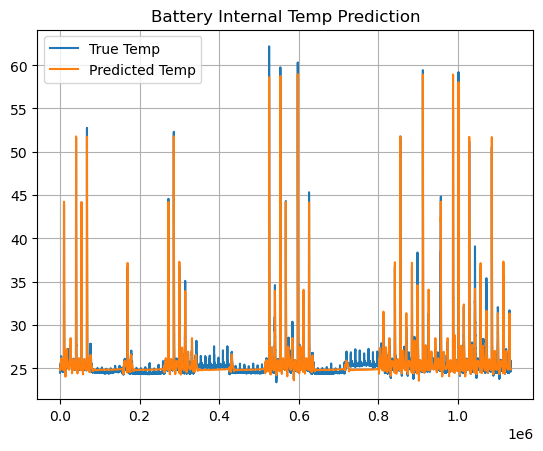

Average Predicted Temperature: 25.44°C
Epoch 1 Loss: 0.0009
Epoch 2 Loss: 0.0007
Epoch 3 Loss: 0.0007
Epoch 4 Loss: 0.0007


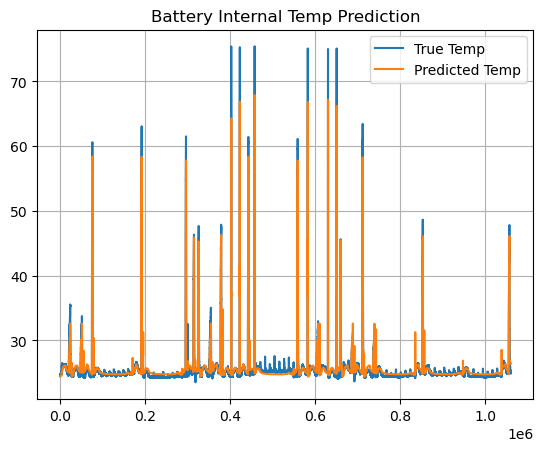

Average Predicted Temperature: 25.59°C
Epoch 1 Loss: 0.0012
Epoch 2 Loss: 0.0008
Epoch 3 Loss: 0.0007
Epoch 4 Loss: 0.0006


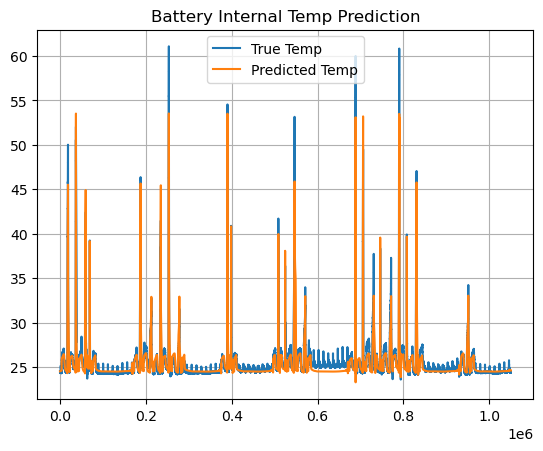

Average Predicted Temperature: 25.35°C

🔥 Best battery for hot conditions (45°C): NCA — Avg Temp: 25.35°C


In [20]:
battery_paths = {
    'LFP': '/home/aadya/scratch/EE499/battery/lfp_25degC',
    'NMC': '/home/aadya/scratch/EE499/battery/nmc_25degC',
    'NCA': '/home/aadya/scratch/EE499/battery/nca_25degC',
}

results = {}

for name, path in battery_paths.items():
    dataset = BatterySequenceDataset(path, external_temp=45.0)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
    model = TempLSTM(input_size=5)
    train_model(model, dataloader)
    avg_temp = evaluate_model(model, DataLoader(dataset, batch_size=64), dataset.scaler_y)
    results[name] = avg_temp

best_battery = min(results, key=results.get)
print(f"\n🔥 Best battery for hot conditions (45°C): {best_battery} — Avg Temp: {results[best_battery]:.2f}°C")
